In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import ardent
# from scipy.ndimage import zoom
import time
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
# from proglearn.sims import generate_gaussian_parity

import pandas as pd

In [235]:
context = sns.plotting_context(context="talk", font_scale=1.5)
sns.set_context(context)

In [3]:
from sklearn.datasets import make_blobs


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    angle_params=None,
    random_state=None,
):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [4]:
def to_grid(X_task):
    h = 0.01
    x_min, x_max = X_task[:,0].min()-0.1, X_task[:,0].max()+0.1
    y_min, y_max = X_task[:,1].min()-0.1, X_task[:,1].max()+0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    new_X_task = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, new_X_task

In [5]:
def init_forest(max_depth):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    # uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
    #                                         default_transformer_kwargs = default_transformer_kwargs,
    #                                         default_voter_class = default_voter_class,
    #                                         default_voter_kwargs = default_voter_kwargs,
    #                                         default_decider_class = default_decider_class,
    #                                         default_decider_kwargs = default_decider_kwargs)
    return progressive_learner

In [6]:
def grid_to_score(l2f_task, test_task, xx, yy):
    pred = np.empty((len(test_task), ))
    l2f_task = l2f_task.reshape(xx.shape)
    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = l2f_task[x_ind, y_ind]
    # pred = pred.reshape((1,-1))

    return pred

In [7]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))
    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]  # y_ind row, x_ind column
    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)

    return pred

In [54]:
def default_lddmm(in_task_pos_reshaped, cross_task_pos_reshaped):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    transform.register(target=moving, template=reference, num_iterations=50)
    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')
    print("finish running lddmm")
    return deformed_moving, transform

In [168]:
def lddmm_reg(in_task_pos_reshaped, cross_task_pos_reshaped, affines):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    n_ite = 50

    try:
        transform.register(target=moving, template=reference, num_iterations=n_ite, initial_affine=affines)
    except RuntimeError:
        try:
            transform.register(target=moving, template=reference, affine_stepsize=0.2, num_iterations=n_ite, initial_affine=affines)
        except RuntimeError:
            try:
                transform.register(target=moving, template=reference, affine_stepsize=0.1, num_iterations=n_ite, initial_affine=affines)
            except RuntimeError:
                return moving, None

    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')
    print("finish running lddmm")
    return deformed_moving, transform

In [300]:
n_task1=100; n_task2=100; n_test=1000; task1_angle=0; task2_angle=20/180*np.pi; n_trees=10

#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

In [301]:
errors = np.zeros(6, dtype=float)

In [302]:
xx1, yy1, test_task1_grid = to_grid(test_task1)
xx2, yy2, test_task2_grid = to_grid(test_task2)

# train on task1 & predict on both

progressive_learner = init_forest(max_depth=ceil(log2(n_task1)))
progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

train1pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
train1pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

train1pred1_reshaped = train1pred1[0][:,0].reshape(xx1.shape)
train1pred2_reshaped = train1pred2[0][:,0].reshape(xx2.shape)

errors[0] = 1 - np.mean(
    grid_to_pred(train1pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
)  # l2f task1 error
errors[1] = 1 - np.mean(
    grid_to_pred(train1pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
)  # l2f task2 error

# train on task2 & predict on both

progressive_learner = init_forest(max_depth=ceil(log2(n_task2)))
progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

train2pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
train2pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

train2pred1_reshaped = train2pred1[0][:,0].reshape(xx1.shape)
train2pred2_reshaped = train2pred2[0][:,0].reshape(xx2.shape)

errors[2] = 1 - np.mean(
    grid_to_pred(train2pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
)  # l2f task1 error
errors[3] = 1 - np.mean(
    grid_to_pred(train2pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
)  # l2f task2 error

In [303]:
# lddmm
train1pred2_deformed, model1 = lddmm_reg(train2pred2_reshaped, train1pred2_reshaped, affine1.T)
errors[4] = 1 - np.mean(
    grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
)  # l2f o lddmm task2 mapped onto task1 error

train2pred1_deformed, model2 = lddmm_reg(train1pred1_reshaped, train2pred1_reshaped, affine2.T)
errors[5] = 1 - np.mean(
    grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
)  # l2f o lddmm task1 mapped onto task2 error

start running lddmm
finish running lddmm
start running lddmm
finish running lddmm


In [304]:
errors

array([0.065, 0.14 , 0.192, 0.122, 0.106, 0.087])

In [276]:
def exp(n_task1, n_task2, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10, rand=None):

    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx1, yy1, test_task1_grid = to_grid(test_task1)
    xx2, yy2, test_task2_grid = to_grid(test_task2)

    errors = np.zeros(6, dtype=float)

    # train on task1 & predict on both

    progressive_learner = init_forest(max_depth=ceil(log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

    train1pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
    train1pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

    train1pred1_reshaped = train1pred1[0][:,0].reshape(xx1.shape)
    train1pred2_reshaped = train1pred2[0][:,0].reshape(xx2.shape)

    errors[0] = 1 - np.mean(
        grid_to_pred(train1pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
    )  # l2f task1 error
    errors[1] = 1 - np.mean(
        grid_to_pred(train1pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
    )  # l2f task2 error

    # train on task2 & predict on both

    progressive_learner = init_forest(max_depth=ceil(log2(n_task2)))
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    train2pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
    train2pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

    train2pred1_reshaped = train2pred1[0][:,0].reshape(xx1.shape)
    train2pred2_reshaped = train2pred2[0][:,0].reshape(xx2.shape)

    errors[2] = 1 - np.mean(
        grid_to_pred(train2pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
    )  # l2f task1 error
    errors[3] = 1 - np.mean(
        grid_to_pred(train2pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
    )  # l2f task2 error

    # # lddmm estimating affines
    # train1pred2_deformed, model1 = default_lddmm(train2pred2_reshaped, train1pred2_reshaped)
    # errors[4] = 1 - np.mean(
    #     grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
    # )  # l2f o lddmm task2 mapped onto task1 error

    # train2pred1_deformed, model2 = default_lddmm(train1pred1_reshaped, train2pred1_reshaped)
    # errors[5] = 1 - np.mean(
    #     grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
    # )  # l2f o lddmm task1 mapped onto task2 error

    # lddmm using estimated affines
    train1pred2_deformed, model1 = lddmm_reg(train2pred2_reshaped, train1pred2_reshaped, affine1.T)
    errors[4] = 1 - np.mean(
        grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
    )  # l2f o lddmm task2 mapped onto task1 error

    train2pred1_deformed, model2 = lddmm_reg(train1pred1_reshaped, train2pred1_reshaped, affine2.T)
    errors[5] = 1 - np.mean(
        grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
    )  # l2f o lddmm task1 mapped onto task2 error

    # return errors, model1.affine.T, model2.affine.T
    return errors

In [279]:
e = exp(500,500,n_trees=10, task2_angle=70/180*np.pi)

start running lddmm
finish running lddmm
start running lddmm
finish running lddmm


In [280]:
e

array([0.039, 0.85 , 0.829, 0.072, 0.049, 0.071])

### rotation angle = pi/4; varying sample sizes

In [147]:
# estimate affines for either task

start_time = time.time()
mc_rep = 100

errors_all = {}
affines_model1 = {}
affines_model2 = {}
n_train = [500]

for i in range(len(n_train)):
    print("n_train =", n_train[i])
    results = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train[i], n_task2=n_train[i], n_trees=20) for _ in range(mc_rep)
        )
    )
    errors_all[i] = results[:, 0]
    affines_model1[i] = results[:, 1]
    affines_model2[i] = results[:, 2]
print("--- %s seconds ---" % (time.time() - start_time))

n_train = 500
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
--- 1086.139965057373 seconds ---
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.1min finished


In [158]:
# find trials where task1/task2 was (almost) successfully predicted
inds1 = np.array([errors_all[0][i][-2] for i in range(100)]) < 0.5
inds2 = np.array([errors_all[0][i][-1] for i in range(100)]) < 0.5

In [165]:
# estimated affines for task1/task2
affine1 = np.mean(np.array([affines_model1[0][i] for i in range(100)])[inds1], axis=0)
affine2 = np.mean(np.array([affines_model2[0][i] for i in range(100)])[inds2], axis=0)

In [166]:
affine1

array([[ 0.81473565,  0.57445664,  0.        ],
       [-0.57445664,  0.81473565,  0.        ],
       [-0.58150549, -0.13890741,  1.        ]])

In [167]:
affine2

array([[ 0.79482773, -0.60329648,  0.        ],
       [ 0.60329648,  0.79482773,  0.        ],
       [ 0.34364547, -1.10930593,  1.        ]])

In [217]:
# compute generalization errors

start_time = time.time()
mc_rep = 50

errors_all_affine = {}
n_train = [100, 200, 300, 400, 500, 600, 700, 800]

for i in range(len(n_train)):
    print("n_train =", n_train[i])
    errors = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train[i], n_task2=n_train[i], n_trees=20) for _ in range(mc_rep)
        )
    )
    errors_all_affine[i] = errors

print("--- %s seconds ---" % (time.time() - start_time))

n_train = 100
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 200
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 300
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 400
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 500
[Parallel(n_jobs=-

In [224]:
import pickle 

pickle_out = open("errors-pi_4-n_sample=100_800_100-n_rep=50-initial_affine.pickle", "wb")
pickle.dump(errors_all_affine, pickle_out)
pickle_out.close()

### plot results

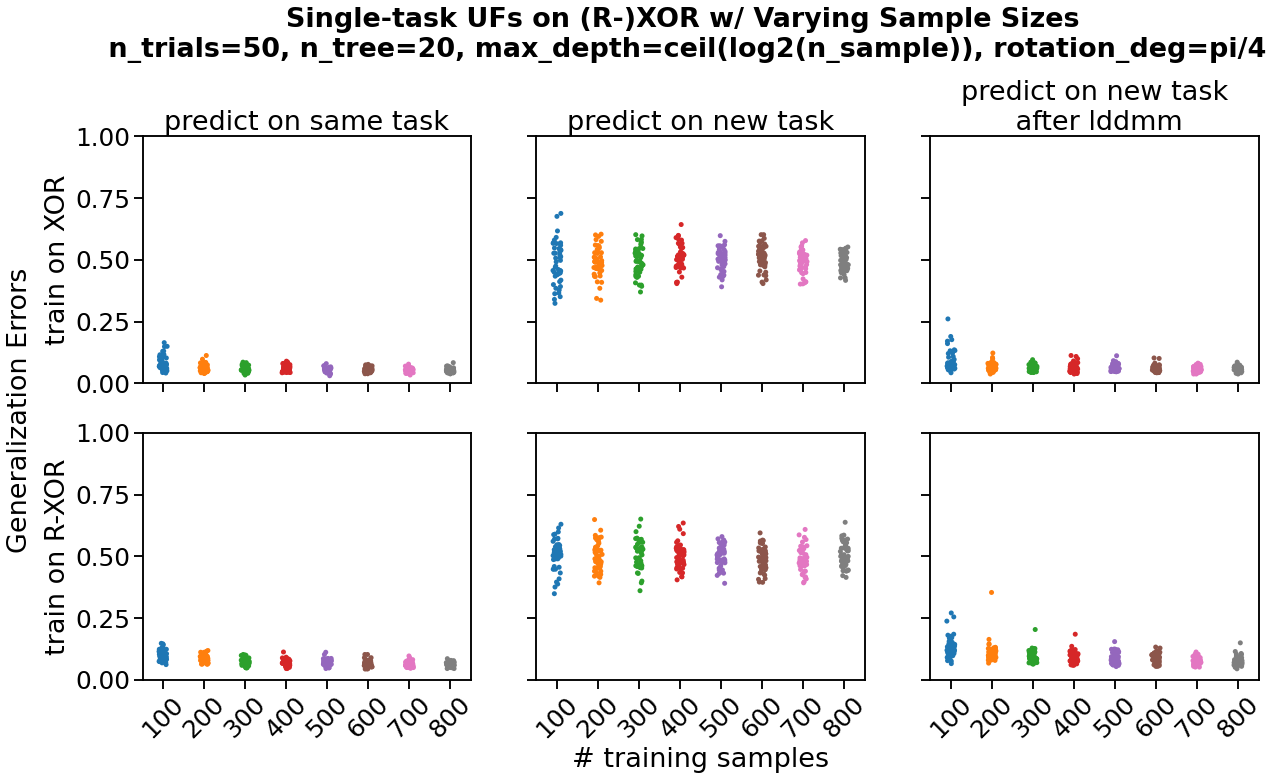

In [239]:
n_samples = np.arange(100,900,100)
fig, axs = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)
seqs = [0,1,4,3,2,5]
idx = -1
for i in range(2):
    for j in range(3):
        idx += 1
        e = np.array([errors_all_affine[n][:,seqs[idx]] for n in range(8)]).T
        df = pd.DataFrame(e)
        df = df.melt(value_vars=df.columns)
        ax = axs[i,j]
        sns.stripplot(data=df, x='variable', y='value', ax=ax)
        plt.ylim((0,1))
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel('train on XOR')
            if j == 0:
                ax.set_title('predict on same task')
            elif j == 1:
                ax.set_title('predict on new task')
            else:
                ax.set_title('predict on new task\n after lddmm')
        else:
            ax.set_ylabel('train on R-XOR')
            ax.set_xticklabels((ax.get_xticks()+1) * 100, rotation=45)
            if j == 1:
                ax.set_xlabel('# training samples')
        if j != 0:
            ax.set_ylabel('')
fig.text(0.5, 0.99, 'Single-task UFs on (R-)XOR w/ Varying Sample Sizes\n n_trials=50, n_tree=20, max_depth=ceil(log2(n_sample)), rotation_deg=pi/4', ha='center', fontweight='bold')
fig.text(0.04, 0.5, 'Generalization Errors', rotation=90, ha='center', va='center')
# plt.tight_layout()
# plt.savefig('1-1', bbox_inches='tight')

### varying rotation angle; training sample = 500

In [313]:
start_time = time.time()
mc_rep = 50

# errors_all_affine_angles = {}
n_train = 500
# task2_angles = np.array([20, 30, 40, 50, 60, 70]) * np.pi/180
task2_angles = np.array([70]) * np.pi/180

for i in range(len(task2_angles)):
    print("task2_angle =", task2_angles[i])
    errors = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train, n_task2=n_train, n_trees=20, task2_angle=task2_angles[i]) for _ in range(mc_rep)
        )
    )
    # errors_all_affine_angles[i] = errors

print("--- %s seconds ---" % (time.time() - start_time))

task2_angle = 1.2217304763960306
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
--- 525.6686661243439 seconds ---
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished


In [317]:
errors_all_affine_angles[5] = errors

In [318]:
import pickle 

pickle_out = open("errors-angles=20_70_10-n_sample=500-n_rep=50-initial_affine.pickle", "wb")
pickle.dump(errors_all_affine_angles, pickle_out)
pickle_out.close()

In [23]:
pickle_in = open("errors-angles=20_70_10-n_sample=500-n_rep=50.pickle", "rb")
e4 = pickle.load(pickle_in)

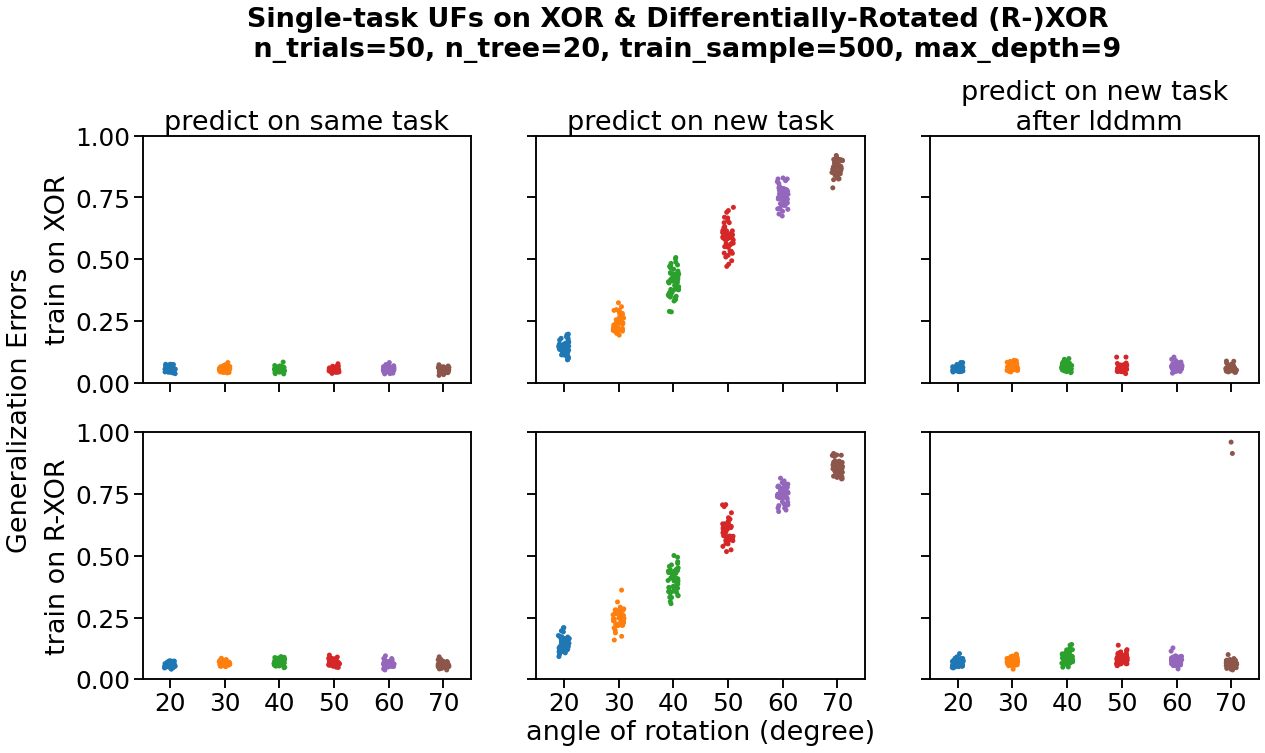

In [322]:
fig, axs = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)
idx = -1
seqs = [0,1,4,3,2,5]
for i in range(2):
    for j in range(3):
        idx += 1
        e = np.array([errors_all_affine_angles[n][:,seqs[idx]] for n in range(6)]).T
        df = pd.DataFrame(e)
        df = df.melt(value_vars=df.columns)
        ax = axs[i,j]
        sns.stripplot(data=df, x='variable', y='value', ax=ax)
        plt.ylim((0,1))
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel('train on XOR')
            if j == 0:
                ax.set_title('predict on same task')
            elif j == 1:
                ax.set_title('predict on new task')
            else:
                ax.set_title('predict on new task\n after lddmm')
        else:
            ax.set_ylabel('train on R-XOR')
            ax.set_xticklabels((ax.get_xticks()+2) * 10)
            if j == 1:
                ax.set_xlabel('angle of rotation (degree)')
        if j != 0:
            ax.set_ylabel('')
fig.text(0.5, 0.99, 'Single-task UFs on XOR & Differentially-Rotated (R-)XOR \n n_trials=50, n_tree=20, train_sample=500, max_depth=9', ha='center', fontweight='bold')
fig.text(0.04, 0.5, 'Generalization Errors', rotation=90, ha='center', va='center')
# plt.tight_layout()
plt.savefig('1-2', bbox_inches='tight')